# Notebook for Performing ComBat-GAM Data Harmonization

## Why Harmonize? 
Despite the fact that multi-cohort brain imaging research projects can attempt to follow a pre-defined processing protocol, heterogeneity across sites still exist in the data due a range of factors, such as differences in MRI scanning devices and acquisition sequences, or differences in software applications. 

This is a significant issue, as research has demonstrated that combining diffusion MRI data from different sites without dealing with  site effects reduces power to detect expected associations between DTI metrics and age. Accordingly, between-site variability is thus a ‘nuisance’ that needs to either be modeled statistically, or be addressed through the use of data harmonization.

## ComBat-GAM Harmonization
ComBat (and its derivatives) have been developed to adjust batch effects in biological data, and have been used effectively for reducing site-effects in diffusion MRI data. These methods are designed to remove site-associated differences while preserving variation due to biologically relevant variables such as age, sex, and diagnosis. A derivative of ComBat, which includes a generalized additive model to model the non-linear effects of variables like age (ComBat-GAM) has been developed and which is able to more effectively capture age-related differences in brain imaging metrics across the lifespan compared to other statistical models.

## Aim
This notebook thus demonstrates how to remove non-linear site effects from diffusion MRI data, before presenting the results to demonstrate the effect of this method.

### Notebook Setup

In [1]:
# Import packages
import numpy as np
import pandas as pd
from neuroHarmonize import harmonizationLearn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import ptitprince as pt

### Data Curation

In [31]:
# Load in our dataset
df = pd.read_csv('./full_dataframe_20221128.csv', header=0, index_col='subjectID')

# Drop rows where age, sex or diagnosis information is missing
df = df.dropna(subset=['diagnosis', 'sex', 'age'])

# Change column names to conform with NeuroHarmonize's api
df.rename(columns = {'site':'SITE'}, inplace = True)

# Round ages and disease duration to two decimal places
df['age'] = df['age'].round(decimals=2)
df['disease_duration'] = df['disease_duration'].round(decimals=2)

### Take a look at the data

In [32]:
# Get some information on our dataframe
subjects, variables = df.shape

print(f"Number of subjects: {subjects}")
print(f"Number of variables: {variables}")

Number of subjects: 2503
Number of variables: 269


In [33]:
# Get a list of our ROI data
roi_list = list(df.columns[17:])

# Create a dataframe of our ROI data
df_roi = df[roi_list]

# Get a list of our covariates we want whose variance we want to preserve in the data
# covars_list = ["SITE", "diagnosis", 'age', 'sex']
covars_list = ["SITE", 'age', 'sex']

# Create a dataframe of our covariates data whose variance we want to preserve in the data
df_covars = df[covars_list]

# Get a list of our extra covariates we want to add back to the data at the end
extras_list = list(['site_codes', 'diagnosis', 'disease_duration', 'years_education',
                    'H_Y', 'HY1234_combined', 'MoCA', 'MMSE', 'UPDRS_III_ON',
                    'UPDRS_III_OFF', 'MDS_UPDRS_III_ON', 'MDS_UPDRS_III_OFF',
                    'PREDICT_MDS_UPDRS_III_ON', 'PREDICT_MDS_UPDRS_III_OFF'])

# Create a dataframe of our extra covariates we want to add back to the data at the end
df_extras = df[extras_list]

First we want to do some plotting, so we can get a visual sense of whether there are any relatinoships between different sites and particular DTI metrics.

<Figure size 576x576 with 0 Axes>

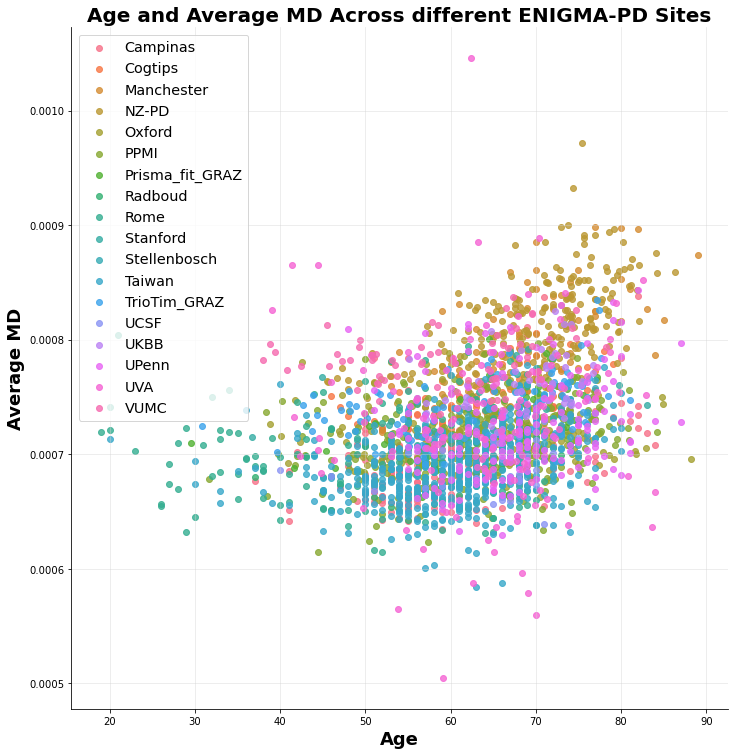

<Figure size 432x288 with 0 Axes>

In [34]:
# Let's do some plotting
plt.figure(figsize=(8,8))

# Main figure
sns.lmplot(x="age", 
           y="Average-MD", 
           data=df, 
           fit_reg=False, 
           hue='SITE',
           height=10,
           legend=False)

# Change legend text size
plt.legend(fontsize='x-large', 
           title_fontsize='32', 
           loc='upper left')

# Set a label for our x-axis
plt.xlabel("Age",
            fontweight ='bold',
            size=18)

# Set a label for our y-axis
plt.ylabel("Average MD",
           fontweight ='bold',
           size=18)

# Add a title
plt.title('Age and Average MD Across different ENIGMA-PD Sites', 
          fontsize=20, 
          fontweight='bold')

# Add a grid
plt.grid(color='lightgray', 
         alpha=0.5, 
         zorder=1)

plt.show()

# https://matplotlib.org/stable/tutorials/colors/colormaps.html

From this we can see that there is a positive association between age and MD, but what we can also see is that some of the outliers look to all come from the same site, which means we might need to harmonize the data.

### First we need to transform our data to NumPy arrays and transpose it

In [12]:
# Convert our pandas dataframe to a numpy array
df_array = np.array(df_roi)

# Transpose it so each subject is in a column
df_array_T = df_array.transpose()

### Now We run the ComBat-GAM Model, specifying non-linear covariate effects for age

In [35]:
# run harmonization and store the adjusted data
my_model, my_data_adj = harmonizationLearn(df_array, df_covars, smooth_terms=['age'])


[neuroHarmonize]: smoothing more than 10 variables may take several minutes of computation.


In [36]:
# Let's look at the shape of our harmonized data (checks out as it matches with our df_roi raw data)
my_data_adj.shape

(2503, 252)

### Now Let's Convert this harmonized data back to a pandas df, and then merge it with our other data

In [37]:
df_data_harmonized = pd.DataFrame(my_data_adj)

# Get the index names from our original dataframe
df_data_harmonized.index=df_roi.index

# Get the column names from our original dataframe
df_data_harmonized.columns=df_roi.columns

# Now let's merge some dataframes
df_intermediate = pd.merge(df_covars, df_extras, left_index=True, right_index=True)

# One more merge
df_final = pd.merge(df_intermediate, df_data_harmonized, left_index=True, right_index=True)

### Before and After Harmonization
Now we want to show how the data looks before and after it has been harmonized. 

In [39]:
# Let's create a dataframe that has our Average FA/MD values before Harmonization
df_raw_md = df[['age', 'Average-MD']].reset_index()
df_raw_fa = df[['age', 'CC-FA']].reset_index()

# Create a column showing that this data is raw
df_raw_fa['Processing'] = 'Raw'
df_raw_md['Processing'] = 'Raw'

# Drop that ID column
df_raw_fa.drop('subjectID', axis=1, inplace=True)
df_raw_md.drop('subjectID', axis=1, inplace=True)

# Now let's create a dataframe that has our Average FA/MD values after harmonization (with age)
df_harm_fa = df_final[['age', 'CC-FA']].reset_index()
df_harm_md = df_final[['age', 'Average-MD']].reset_index()

# Create a column showing that this data is harmonized
df_harm_fa['Processing'] = 'Harmonized'
df_harm_md['Processing'] = 'Harmonized'

# Drop that ID column
df_harm_fa.drop('subjectID', axis=1, inplace=True)
df_harm_md.drop('subjectID', axis=1, inplace=True)

# Now let's concatenate our FA dataframe vertically
df_display_fa = pd.concat([df_raw_fa, df_harm_fa])

# Now let's concatenate our MD dataframe vertically
df_display_md = pd.concat([df_raw_md, df_harm_md])

### Plot the Data for FA of the Corpus Callosum

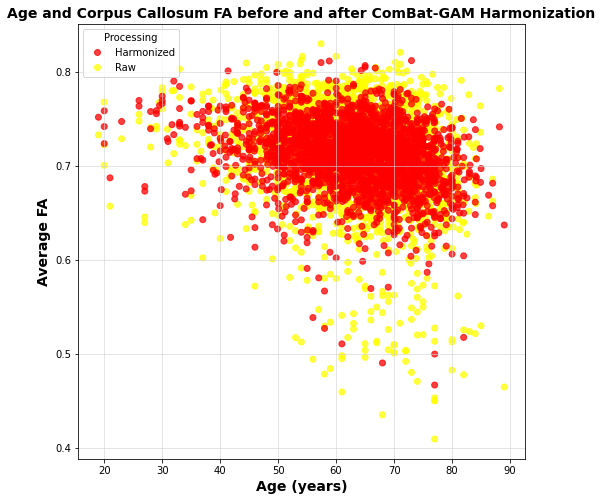

In [43]:
# Let's plot
plt.figure(figsize=(8,8))
scatter = plt.scatter(x=df_display_fa.age,
                      y=df_display_fa['CC-FA'],
                      c=df_display_fa.Processing.astype('category').cat.codes,
                      cmap=cm.autumn,
                      alpha=0.75)

plt.xlabel("Age (years)",
            fontweight ='bold',
            size=14)

plt.ylabel("Average FA",
           fontweight ='bold',
           size=14)

# Add legend names
names = ['Harmonized', 'Raw']

plt.legend(handles=scatter.legend_elements()[0],
           labels=names,
           title="Processing")

# Add a title
plt.title('Age and Corpus Callosum FA before and after ComBat-GAM Harmonization', fontsize=14, fontweight='bold')

# Add a grid
plt.grid(color='lightgray', alpha=0.75, zorder=1)

# https://matplotlib.org/stable/tutorials/colors/colormaps.html

### Plot the Data for MD
Now we are going to plot the MD data before and after harmonization. Data for each subject was generated as an averagae from across the whole brain.

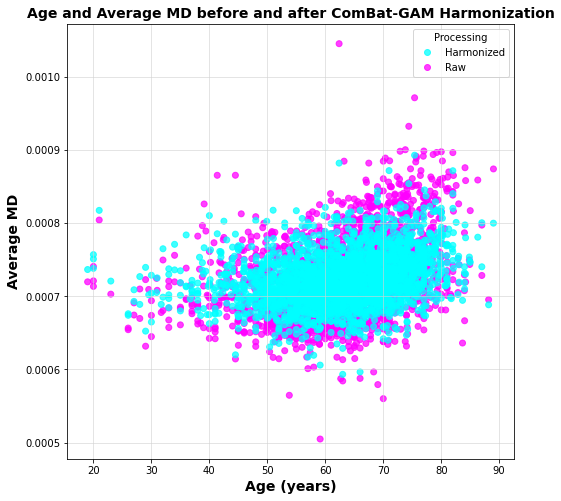

In [44]:
# Let's plot
plt.figure(figsize=(8,8))
scatter = plt.scatter(x=df_display_md['age'],
                      y=df_display_md['Average-MD'],
                      c=df_display_md.Processing.astype('category').cat.codes,
                      cmap=cm.cool,
                      alpha=0.75)

plt.xlabel("Age (years)",
            fontweight ='bold',
            size=14)

plt.ylabel("Average MD",
           fontweight ='bold',
           size=14)

# Add legend names
names = ['Harmonized', 'Raw']

plt.legend(handles=scatter.legend_elements()[0],
           labels=names,
           title="Processing")

# Add a title
plt.title('Age and Average MD before and after ComBat-GAM Harmonization', fontsize=14, fontweight='bold')

# Add a grid
plt.grid(color='lightgray', alpha=0.75, zorder=1)